/tmp/ipykernel_5051/2395156929.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/tmp/ipykernel_5051/2395156929.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels   = torch.tensor(labels, dtype=torch.float32)


epoch 1, loss: 0.08
epoch 2, loss: 0.13
epoch 3, loss: 0.03
epoch 4, loss: 0.03
epoch 5, loss: 0.14
epoch 6, loss: 0.03
epoch 7, loss: 0.02
epoch 8, loss: 0.03
epoch 9, loss: 0.05
epoch 10, loss: 0.03


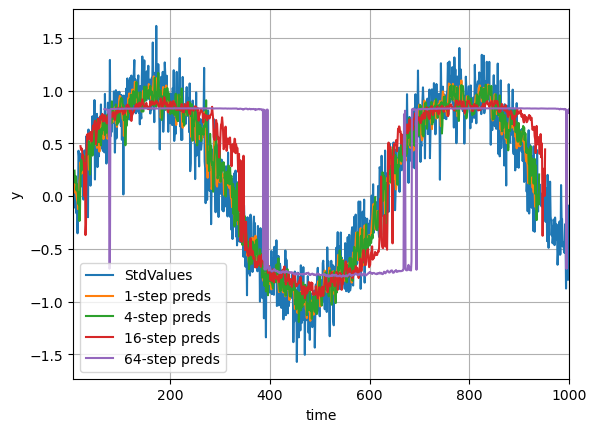

In [24]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

class ResVisualization:
    def __init__(self, xlist:tuple, ylist:tuple, legend_names, is_grid=None,
                xlabel:str=None, ylabel:str=None, title:str=None,
                xlim:list=None, ylim:list=None, line_style:str='-') -> None:
        self.res_dict = {name: (x, y) for name, x, y in zip(legend_names, xlist, ylist)}
        self.is_grid = is_grid
        self.xlim = xlim
        self.ylim  = ylim
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title  = title
        self.line_style = line_style

    def plot_res(self):
        for name, xy_pair in self.res_dict.items():
            plt.plot(xy_pair[0], xy_pair[1], label=name, linestyle=self.line_style)
        if self.is_grid:
            plt.grid()
        if self.title is not None:
            plt.title(self.title)
        if self.xlabel is not None:
            plt.xlabel(self.xlabel)
        if self.ylabel is not None:
            plt.ylabel(self.ylabel)
        if self.xlim is not None:
            plt.xlim(self.xlim)
        if self.ylim is not None:
            plt.ylim(self.ylim)
        if len(self.res_dict) > 1:
            plt.legend()
        plt.show()

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
y = torch.sin(time*0.01) + torch.normal(0, 0.2, size=(T,))
tau = 4 # y[t-tau:t-1] -> y[t]
features = torch.zeros(size=(T-tau, tau)) # 特征维数:tau维
for i in range(tau):
    features[:,i] = y[i: T - tau + i] # 每个样本的特征是 y[t-tau]到y[t-1]的值 注意features是从y中摘取的而不是由模型生成的
labels = y[tau:].reshape((-1,1)) # 数据映射为 y[t-tau:t-1] -> y[t] 比提供的数据样本少了tau个,则丢弃前tau个数据样本
class TimeDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels   = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])
    
    def __len__(self):
        return len(self.features)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def train(train_set, num_epochs, lr, loss_function):
    optimizer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(num_epochs):
        for X, y in train_set:
            optimizer.zero_grad()
            loss = loss_function(net(X), y)
            loss.sum().backward()
            optimizer.step()
        print('epoch %d, loss: %.2f' %(epoch+1, loss))

batch_size, n_train, lr, num_epochs = 16, 600, 0.01, 10 # 前n_train个样本用于训练
train_set = DataLoader(TimeDataset(features[:n_train], labels[:n_train]), batch_size, shuffle=True)
net = nn.Sequential(nn.Linear(tau, 10), nn.ReLU(), nn.Linear(10, 1))
loss_function = nn.MSELoss()
net.apply(init_weights)
train(train_set, num_epochs, lr, loss_function)

# 单步预测:根据y[t-tau:t-1]观测y[t]
one_step_preds = net(features)

# 多(k)步预测:已经有了y[t]的预测,使用自己的预测而不是原始数据来预测y[t+k]
multi_step_preds = torch.zeros(size=(T,))
multi_step_preds[ : n_train+ tau] = y[:n_train+tau]
for i in range(n_train + tau, T):
    multi_step_preds[i] = net(multi_step_preds[(i-tau):i]) # 注意此时除去开始的几步,后面传入模型的features全部是由模型生成的 这样就发生了错误的累积

max_steps = 64
steps = (1, 4, 16, 64)
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps)) 
for i in range(tau): # 列i（i<tau）是来自y的观测，其时间步从（i）到（i+T-tau-max_steps+1）
    features[:, i] = y[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps): # 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

res = ResVisualization(xlist=[time]+[time[tau + i - 1: T - max_steps + i] for i in steps],
                        ylist=[y]+[features[:, (tau + i - 1)].detach().numpy() for i in steps], 
                        legend_names=['StdValues']+[f'{i}-step preds' for i in steps], xlim=[5, 1000],
                        xlabel='time', ylabel='y', is_grid=True)
res.plot_res()